In [0]:
import os
import json 
import matplotlib.pyplot as plt
%tensorflow_version 2.x

from tensorflow.keras.layers import Dropout, Dense,Input,Embedding,Flatten, Reshape, Conv1D, MaxPooling1D, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential,Model
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn import metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import reuters, stopwords
from string import punctuation

import warnings
warnings.filterwarnings('ignore')

In [0]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('reuters')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "drive/My Drive/Datasets/"
fname_x = os.path.join(path,"WebOfScience/WOS11967/X.txt")
fname_y = os.path.join(path,"WebOfScience/WOS11967/Y.txt")

In [0]:
with open(fname_x, encoding="utf-8") as f:
    content_x = f.readlines()
with open(fname_y) as fk:
    content_y = fk.readlines()

In [0]:
label = np.matrix(content_y, dtype=int)
label = np.transpose(label)
np.random.seed(7)
train_text, test_text, y_train, y_test = train_test_split(content_x, label, test_size=0.2, random_state=4)

In [0]:
print('{} topics'.format(int(max(label)+1)))
print('{} train texts'.format(len(train_text)))
print('{} test texts'.format(len(test_text)))

33 topics
9573 train texts
2394 test texts


# Lemmatisation for DNN

In [0]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

def preprocess_text(text):
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and word.isalpha() ]

In [0]:
stopwords_json_en = set(json.load(open(path + 'en.json')))
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
stopwords_time = set(["--","jan","january","feb","february","mar","march","apr","april","may","jun","june","jul","july",
             "aug","august","sept","september","oct","october","nov","november","dec","december"])
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct, stopwords_time)   

In [0]:
X_train_tokens = [preprocess_text(text) for text in train_text]
X_test_tokens = [preprocess_text(text) for text in test_text]

# TF-IDF for DNN

In [0]:
def const(tmp):
    return tmp

In [0]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=const, preprocessor=const, min_df=3, max_df = 0.9)
x_train_tfidf = tfidf_vectorizer.fit_transform(X_train_tokens).toarray()
x_test_tfidf = tfidf_vectorizer.transform(X_test_tokens).toarray()

# GloVe

Для RNN и CNN использовал GloVe, как и авторы статьи, чтобы сравниться с их 
результатами


In [0]:
def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=30000,MAX_SEQUENCE_LENGTH=400):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open(path + "glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)

In [0]:
X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(train_text, test_text)

Found 59409 unique tokens.
(11967, 400)
Total 400000 word vectors.


# Learning

In [0]:
def plot_hist(history):
  plt.figure(figsize=(12, 5))
  plt.subplot(1,2,1)
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], 
          label='Train')
  plt.plot(history.history['val_accuracy'], 
          label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.title('Loss')
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

## DNN

In [0]:
def Build_Model_DNN_Text(feature_size, dropout=0.5):
    model = Sequential()
    node = 512
    nLayers = 0

    model.add(Dense(node,input_dim=feature_size,activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-4),
              bias_regularizer=tf.keras.regularizers.l2(1e-3),
              activity_regularizer=tf.keras.regularizers.l2(1e-3)))
    model.add(Dropout(dropout))
    for i in range(0,nLayers):
        model.add(Dense(node,input_dim=node,activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(33, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [0]:
model_DNN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               7005696   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 33)                16929     
Total params: 7,022,625
Trainable params: 7,022,625
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_save_path = 'best_model.h5'
model_DNN = Build_Model_DNN_Text(x_train_tfidf.shape[1])
history_DNN = model_DNN.fit(x_train_tfidf, y_train,
                              validation_split=0.1,
                              epochs=100,
                              batch_size=32,
                              callbacks=[ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)],
                              verbose=2)

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.57516, saving model to best_model.h5
270/270 - 2s - loss: 3.7822 - accuracy: 0.4212 - val_loss: 3.1115 - val_accuracy: 0.5752
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.57516 to 0.72965, saving model to best_model.h5
270/270 - 2s - loss: 2.8445 - accuracy: 0.6433 - val_loss: 2.6099 - val_accuracy: 0.7296
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.72965 to 0.75470, saving model to best_model.h5
270/270 - 1s - loss: 2.5662 - accuracy: 0.7226 - val_loss: 2.4499 - val_accuracy: 0.7547
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.75470 to 0.78914, saving model to best_model.h5
270/270 - 2s - loss: 2.4359 - accuracy: 0.7558 - val_loss: 2.3807 - val_accuracy: 0.7891
Epoch 5/100

Epoch 00005: val_accuracy improved from 0.78914 to 0.79123, saving model to best_model.h5
270/270 - 2s - loss: 2.3690 - accuracy: 0.7762 - val_loss: 2.3156 - val_accuracy: 0.7912
Epoch 6/100

Epoch 00006: val_accuracy impr

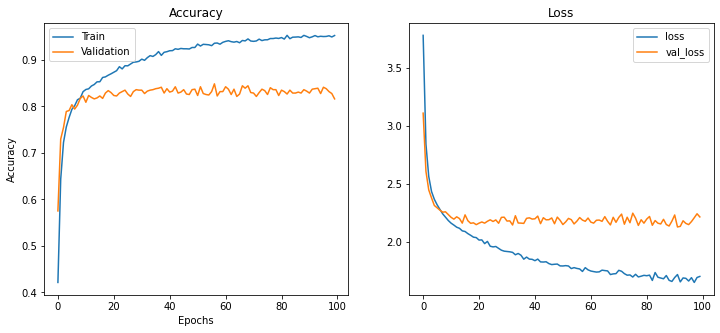

In [0]:
plot_hist(history_DNN)

In [0]:
model_DNN.load_weights(model_save_path)
predicted_DNN = model_DNN.predict(x_test_tfidf)
print(metrics.classification_report(y_test, np.argmax(predicted_DNN, axis=1), digits=3))

              precision    recall  f1-score   support

           0      0.853     0.806     0.829        72
           1      0.800     0.842     0.821        57
           2      0.810     0.904     0.855        52
           3      0.981     0.864     0.919        59
           4      0.884     0.859     0.871        71
           5      0.885     0.742     0.807        62
           6      0.826     0.894     0.859        85
           7      0.906     0.956     0.930        91
           8      0.819     0.855     0.837        69
           9      0.682     0.817     0.744        71
          10      0.733     0.724     0.728        76
          11      0.903     0.767     0.830        73
          12      0.919     0.773     0.840        88
          13      0.810     0.644     0.718        73
          14      0.768     0.803     0.785        66
          15      0.824     0.824     0.824        68
          16      0.922     0.912     0.917        91
          17      0.904    

**ACCURACY WITH DNN: 83.9%**

## CNN

Пробовал разные архитектуры, начиная от простых сверток с несколькими слоями. В итоге лучше всего показала архитектура, взятая отсюда https://github.com/kk7nc/Text_Classification#convolutional-neural-networks-cnn

In [0]:
def Build_Model_CNN_Text(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=400, EMBEDDING_DIM=50, dropout=0.2):

    model = Sequential()

    model = Sequential()
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])),
                                 "into shape",str(len(embedding_vector))," Please make sure your"
                                 " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)

            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)
    convs = []
    filter_sizes = []
    layer = 5
    print("Filter  ",layer)
    for fl in range(0,layer):
        filter_sizes.append((fl+2))

    node = 128
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(node, kernel_size=fsz, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        l_pool = Dropout(0.25)(l_pool)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)
    l_cov1 = Conv1D(node, 5, activation='relu')(l_merge)
    l_cov1 = Dropout(dropout)(l_cov1)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(node, 5, activation='relu')(l_pool1)
    l_cov2 = Dropout(dropout)(l_cov2)
    l_pool2 = MaxPooling1D(30)(l_cov2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(1024, activation='relu') (l_flat)
    l_dense = Dense(512, activation='relu')(l_dense)
    l_dense = Dropout(dropout)(l_dense)
    preds = Dense(nclasses, activation='softmax')(l_dense)
    model = Model(sequence_input, preds)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])



    return model

In [0]:
model_save_path = 'best_model.h5'
model_CNN = Build_Model_CNN_Text(word_index,embeddings_index, 33, EMBEDDING_DIM=50)
model_CNN.summary()

Filter   5
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 400, 50)      2970500     input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 399, 128)     12928       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 398, 128)     19328       embedding_5[0][0]                
_________________________________________________________________________________

In [0]:
history_CNN = model_CNN.fit(X_train_Glove, y_train,
                              validation_split=0.1,
                              epochs=200,
                              batch_size=64,
                              callbacks=[ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)],
                              verbose=2)

Train on 8615 samples, validate on 958 samples
Epoch 1/200
 - 3s - loss: 3.4164 - accuracy: 0.0529 - val_loss: 3.1332 - val_accuracy: 0.1086

Epoch 00001: val_accuracy improved from -inf to 0.10856, saving model to best_model.h5
Epoch 2/200
 - 3s - loss: 2.4566 - accuracy: 0.1938 - val_loss: 2.3638 - val_accuracy: 0.2109

Epoch 00002: val_accuracy improved from 0.10856 to 0.21086, saving model to best_model.h5
Epoch 3/200
 - 3s - loss: 2.0265 - accuracy: 0.3268 - val_loss: 2.0761 - val_accuracy: 0.3382

Epoch 00003: val_accuracy improved from 0.21086 to 0.33820, saving model to best_model.h5
Epoch 4/200
 - 3s - loss: 1.5844 - accuracy: 0.4764 - val_loss: 1.5279 - val_accuracy: 0.4937

Epoch 00004: val_accuracy improved from 0.33820 to 0.49374, saving model to best_model.h5
Epoch 5/200
 - 3s - loss: 1.2226 - accuracy: 0.6087 - val_loss: 1.2393 - val_accuracy: 0.6054

Epoch 00005: val_accuracy improved from 0.49374 to 0.60543, saving model to best_model.h5
Epoch 6/200
 - 3s - loss: 0.948

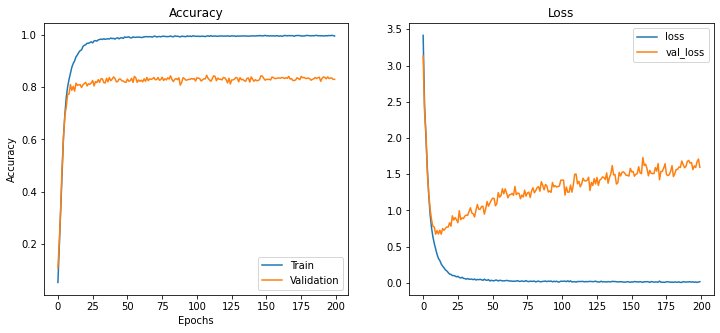

In [0]:
plot_hist(history_CNN)

In [0]:
model_CNN.load_weights(model_save_path)
predicted_CNN = model_CNN.predict(X_test_Glove)
print(metrics.classification_report(y_test, np.argmax(predicted_CNN, axis=1), digits=3))

              precision    recall  f1-score   support

           0      0.853     0.806     0.829        72
           1      0.786     0.772     0.779        57
           2      0.697     0.885     0.780        52
           3      0.877     0.847     0.862        59
           4      0.917     0.930     0.923        71
           5      0.891     0.790     0.838        62
           6      0.920     0.953     0.936        85
           7      0.873     0.978     0.922        91
           8      0.716     0.913     0.803        69
           9      0.754     0.732     0.743        71
          10      0.778     0.645     0.705        76
          11      0.841     0.795     0.817        73
          12      0.857     0.818     0.837        88
          13      0.896     0.822     0.857        73
          14      0.757     0.848     0.800        66
          15      0.954     0.912     0.932        68
          16      0.894     0.923     0.908        91
          17      0.915    

**ACCURACY WITH CNN: 84.7%**

## RNN

In [0]:
def Build_Model_RNN_Text(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=400, EMBEDDING_DIM=50, dropout=0.2):

    model = Sequential()
    hidden_layer = 1
    gru_node = 512

    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))


    print(gru_node)
    for i in range(0,hidden_layer):
        model.add(Bidirectional(GRU(gru_node,return_sequences=True)))
        model.add(Dropout(dropout))
    model.add((Bidirectional(GRU(gru_node))))
    model.add(Dropout(dropout))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))


    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [0]:
model_save_path = 'best_model.h5'
model_RNN = Build_Model_RNN_Text(word_index,embeddings_index, 33, EMBEDDING_DIM=50)
model_RNN.summary()

512
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 50)           2970500   
_________________________________________________________________
bidirectional (Bidirectional (None, 400, 1024)         1732608   
_________________________________________________________________
dropout (Dropout)            (None, 400, 1024)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              4724736   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 33)             

In [0]:
history_RNN = model_RNN.fit(X_train_Glove, y_train,
                              validation_split=0.1,
                              epochs=20,
                              batch_size=64,
                              callbacks=[ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)],
                              verbose=2)

Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.40188, saving model to best_model.h5
135/135 - 48s - loss: 2.6015 - accuracy: 0.2071 - val_loss: 1.8196 - val_accuracy: 0.4019
Epoch 2/20

Epoch 00002: val_accuracy improved from 0.40188 to 0.75052, saving model to best_model.h5
135/135 - 46s - loss: 1.2093 - accuracy: 0.6166 - val_loss: 0.8513 - val_accuracy: 0.7505
Epoch 3/20

Epoch 00003: val_accuracy improved from 0.75052 to 0.82046, saving model to best_model.h5
135/135 - 46s - loss: 0.5998 - accuracy: 0.8241 - val_loss: 0.6051 - val_accuracy: 0.8205
Epoch 4/20

Epoch 00004: val_accuracy improved from 0.82046 to 0.82881, saving model to best_model.h5
135/135 - 46s - loss: 0.3765 - accuracy: 0.8849 - val_loss: 0.5720 - val_accuracy: 0.8288
Epoch 5/20

Epoch 00005: val_accuracy did not improve from 0.82881
135/135 - 46s - loss: 0.2731 - accuracy: 0.9158 - val_loss: 0.6432 - val_accuracy: 0.8225
Epoch 6/20

Epoch 00006: val_accuracy improved from 0.82881 to 0.84029, saving

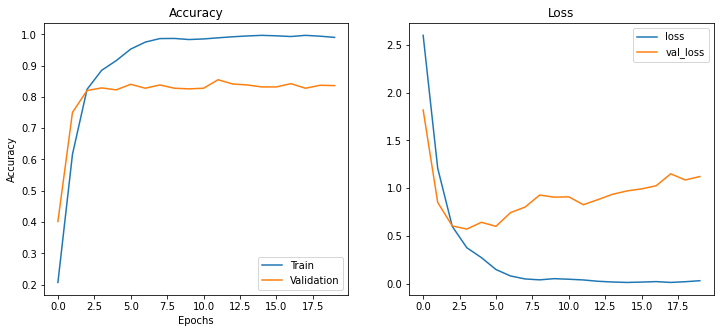

In [0]:
plot_hist(history_RNN)

In [0]:
model_RNN.load_weights(model_save_path)
predicted_RNN = model_RNN.predict(X_test_Glove)
print(metrics.classification_report(y_test, np.argmax(predicted_RNN, axis=1), digits=3))

              precision    recall  f1-score   support

           0      0.871     0.847     0.859        72
           1      0.818     0.789     0.804        57
           2      0.870     0.769     0.816        52
           3      0.926     0.847     0.885        59
           4      0.867     0.915     0.890        71
           5      0.911     0.823     0.864        62
           6      0.876     0.918     0.897        85
           7      0.896     0.945     0.920        91
           8      0.753     0.884     0.813        69
           9      0.730     0.648     0.687        71
          10      0.710     0.579     0.638        76
          11      0.797     0.808     0.803        73
          12      0.722     0.795     0.757        88
          13      0.816     0.849     0.832        73
          14      0.776     0.894     0.831        66
          15      0.889     0.941     0.914        68
          16      0.883     0.912     0.897        91
          17      0.953    

**ACCURACY WITH RNN: 85%**